In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = 'fruits_dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(100),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

In [4]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 9124


In [5]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 100, 100])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Avocado (2)


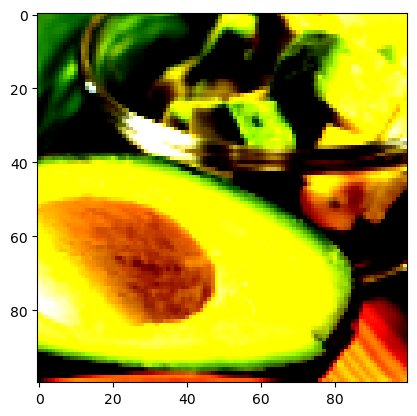

In [7]:
show_image(*dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [9]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(7756, 456, 912)

In [10]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


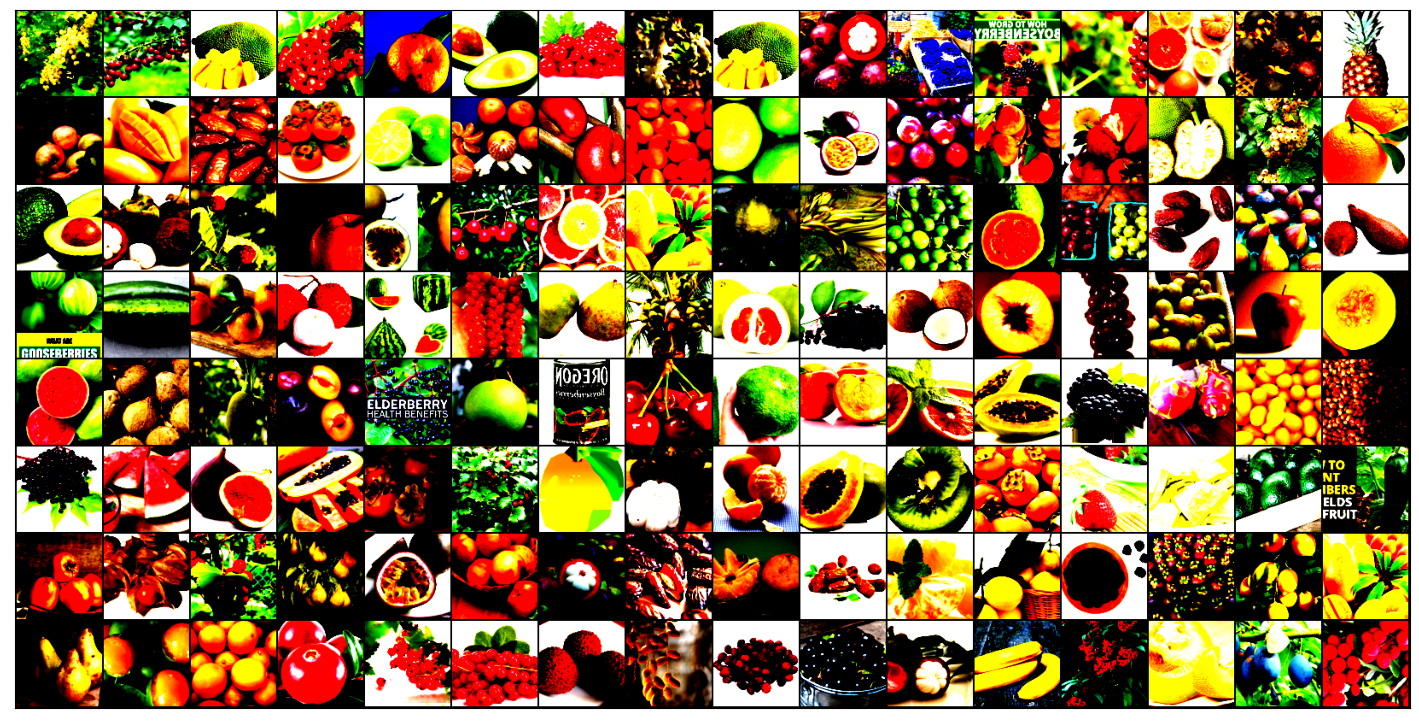

In [11]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [12]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*100*100
output_size = 55

In [16]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 50 x 50

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),#output :256*25*25
            nn.MaxPool2d(5, 5), # output: 256 x 5 x 5

            nn.Flatten(), 
            nn.Linear(256*5*5, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
            
        
    def forward(self, xb):
        return self.network(xb)

In [17]:
# Model print
num_classes = 55
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [18]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 100, 100])
out.shape: torch.Size([128, 55])
out[0]: tensor([ 0.0408,  0.0187,  0.0261,  0.0094, -0.0248, -0.0241,  0.0511,  0.0208,
        -0.0260, -0.0290,  0.0405, -0.0398,  0.0199, -0.0378, -0.0175, -0.0280,
        -0.0348, -0.0046,  0.0387, -0.0254,  0.0347, -0.0363, -0.0229, -0.0366,
        -0.0195, -0.0006,  0.0071,  0.0002,  0.0076,  0.0005, -0.0074,  0.0251,
         0.0400,  0.0201,  0.0322, -0.0215,  0.0020, -0.0365, -0.0092,  0.0033,
        -0.0082, -0.0102, -0.0375, -0.0314, -0.0128,  0.0180,  0.0389,  0.0114,
        -0.0172,  0.0275, -0.0176,  0.0041, -0.0336, -0.0199, -0.0217],
       grad_fn=<SelectBackward0>)


In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6400, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(model, device)

In [23]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 4.008218288421631, 'val_acc': 0.04507812485098839}]

In [24]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001

In [25]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.7832, val_loss: 3.6379, val_acc: 0.1166


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.5696, val_loss: 3.5254, val_acc: 0.1567


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.4498, val_loss: 3.3667, val_acc: 0.2330


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.2368, val_loss: 3.1172, val_acc: 0.3209


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.9436, val_loss: 2.9569, val_acc: 0.3961


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7665, val_loss: 2.7754, val_acc: 0.4452


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.6021, val_loss: 2.7584, val_acc: 0.4680


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.4888, val_loss: 2.7980, val_acc: 0.4827


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.3781, val_loss: 2.6824, val_acc: 0.5037


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.2497, val_loss: 2.5846, val_acc: 0.5251


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [10], train_loss: 2.1211, val_loss: 2.6393, val_acc: 0.5262


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.9939, val_loss: 2.5783, val_acc: 0.5655


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.8542, val_loss: 2.5622, val_acc: 0.5696


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.6905, val_loss: 2.3966, val_acc: 0.6045


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.5930, val_loss: 2.5112, val_acc: 0.6033


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.4046, val_loss: 2.6738, val_acc: 0.6019


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.2897, val_loss: 2.5906, val_acc: 0.5680


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.1611, val_loss: 2.6196, val_acc: 0.6412


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.0128, val_loss: 2.9160, val_acc: 0.6239


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.9091, val_loss: 2.9476, val_acc: 0.6490


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.7860, val_loss: 2.9818, val_acc: 0.6417


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6943, val_loss: 3.0959, val_acc: 0.6584


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.5926, val_loss: 3.3488, val_acc: 0.6340


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.5363, val_loss: 3.5660, val_acc: 0.6531


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4839, val_loss: 3.7650, val_acc: 0.6542


In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

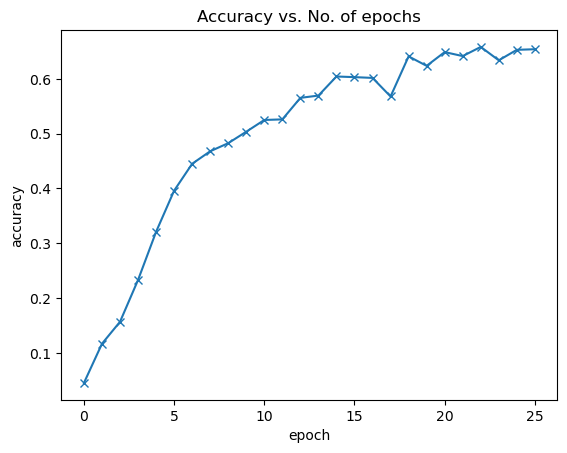

In [27]:
plot_accuracies(history)

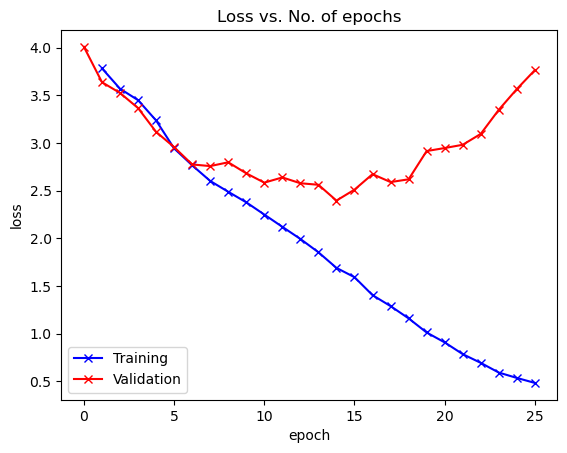

In [28]:
plot_losses(history)

In [29]:
evaluate(model, test_loader)

{'val_loss': 3.739223003387451, 'val_acc': 0.6328125}